<a href="https://colab.research.google.com/github/bcataldo3/plantilla_curso_python/blob/main/docs/Clase_04 - R - Modelo K-Medias Caso Estudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo K-Medias - Caso Estudio
## Caso de Estudio

En este capítulo, vamos a utilizar el conocido conjunto de datos Breast Cancer Wisconsin (cáncer de mamas de Wisconsin) para realizar un análisis de conglomerados. Originalmente, el conjunto de datos se propuso con el fin de entrenar clasificadores; sin embargo, también puede ser muy útil para un análisis de conglomerados sin tener en cuenta sus etiquetas (si es un tumor benigno o maligno). Contiene 569 registros compuestos por 32 atributos (incluyendo el diagnóstico y un número de identificación). Todos los atributos están estrictamente relacionados con propiedades biológicas y morfológicas de los tumores.

Nuestro objetivo será validar hipótesis genéricas considerando la verdad fundamental (tumor benigno o maligno) y las propiedades estadísticas del conjunto de datos. Antes de continuar, es importante aclarar algunos puntos.

+ El conjunto de datos es de alta dimensionalidad y los grupos son no convexos (por lo que no podemos esperar una segmentación perfecta).

+ Nuestro objetivo no es utilizar un algoritmo de agrupamiento para obtener los resultados de un clasificador. La verdad fundamental debe tenerse en cuenta solo como una indicación genérica de un posible agrupamiento.

+ El objetivo de este ejemplo es mostrar cómo realizar un breve análisis preliminar, seleccionar el número óptimo de grupos y validar los resultados finales.

Procedemos a cargar la data y revisar algunas variables.

In [1]:
###############
# Cargar librerías
library(dplyr)
library(ggplot2)
library(cluster)

# Cargar datos desde Google Drive
url <- "https://drive.google.com/uc?id=1LG6hb0duLtnSiFhT9JWFNuo8qDxHV08W"
df <- read.csv(url, header = FALSE)

# Definir los nombres de las columnas (asegúrate de que coincidan con tu dataset de Python)
names(df) <- c('id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst')

# Suponiendo que df es tu dataframe en R
desc <- df %>%
  summarise(across(where(is.numeric), list(
    mean = ~mean(., na.rm = TRUE),
    sd = ~sd(., na.rm = TRUE),
    min = ~min(., na.rm = TRUE),
    max = ~max(., na.rm = TRUE),
    median = ~median(., na.rm = TRUE)
  )))

print(desc)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




   id_mean     id_sd id_min    id_max id_median radius_mean_mean radius_mean_sd
1 30371831 125020586   8670 911320502    906024         14.12729       3.524049
  radius_mean_min radius_mean_max radius_mean_median texture_mean_mean
1           6.981           28.11              13.37          19.28965
  texture_mean_sd texture_mean_min texture_mean_max texture_mean_median
1        4.301036             9.71            39.28               18.84
  perimeter_mean_mean perimeter_mean_sd perimeter_mean_min perimeter_mean_max
1            91.96903          24.29898              43.79              188.5
  perimeter_mean_median area_mean_mean area_mean_sd area_mean_min area_mean_max
1                 86.24       654.8891     351.9141         143.5          2501
  area_mean_median smoothness_mean_mean smoothness_mean_sd smoothness_mean_min
1            551.1           0.09636028         0.01406413             0.05263
  smoothness_mean_max smoothness_mean_median compactness_mean_mean
1            

Invitamos al lector a verificar los valores de todos los atributos, incluso si estamos enfocando nuestra atención solo en un subconjunto. Dejamos algunas observaciones acerca del manejo que tendremos de la data.

* En particular, debemos observar las diferentes escalas que existen entre los primeros ocho atributos. Las desviaciones estándar van desde 0.01 hasta 350, lo que significa que muchos vectores podrían ser extremadamente similares solo debido a uno o dos atributos.
* Por otro lado, normalizar el valor con una escala de varianza dará a todos los atributos la misma responsabilidad (por ejemplo, area_mean está limitada entre 143.5 y 2501, mientras que smoothness_mean está limitada entre 0.05 y 0.16. Forzarlos a tener la misma varianza puede influir en el impacto biológico de los factores y, como no tenemos ninguna indicación específica, no estamos autorizados a tomar esa decisión).
* Claramente, algunos atributos tendrán un mayor peso en el proceso de agrupación y aceptamos su influencia principal como una condición relacionada con el contexto

Revisaremos la diferencia en distribución de algunos de los atributos de la data (perimeter_mean, area_mean, smoothness_mean, concavity_mean, y symmetry_mean)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘labelled’, ‘broom.helpers’, ‘patchwork’, ‘Rcpp’, ‘ggstats’, ‘plyr’


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



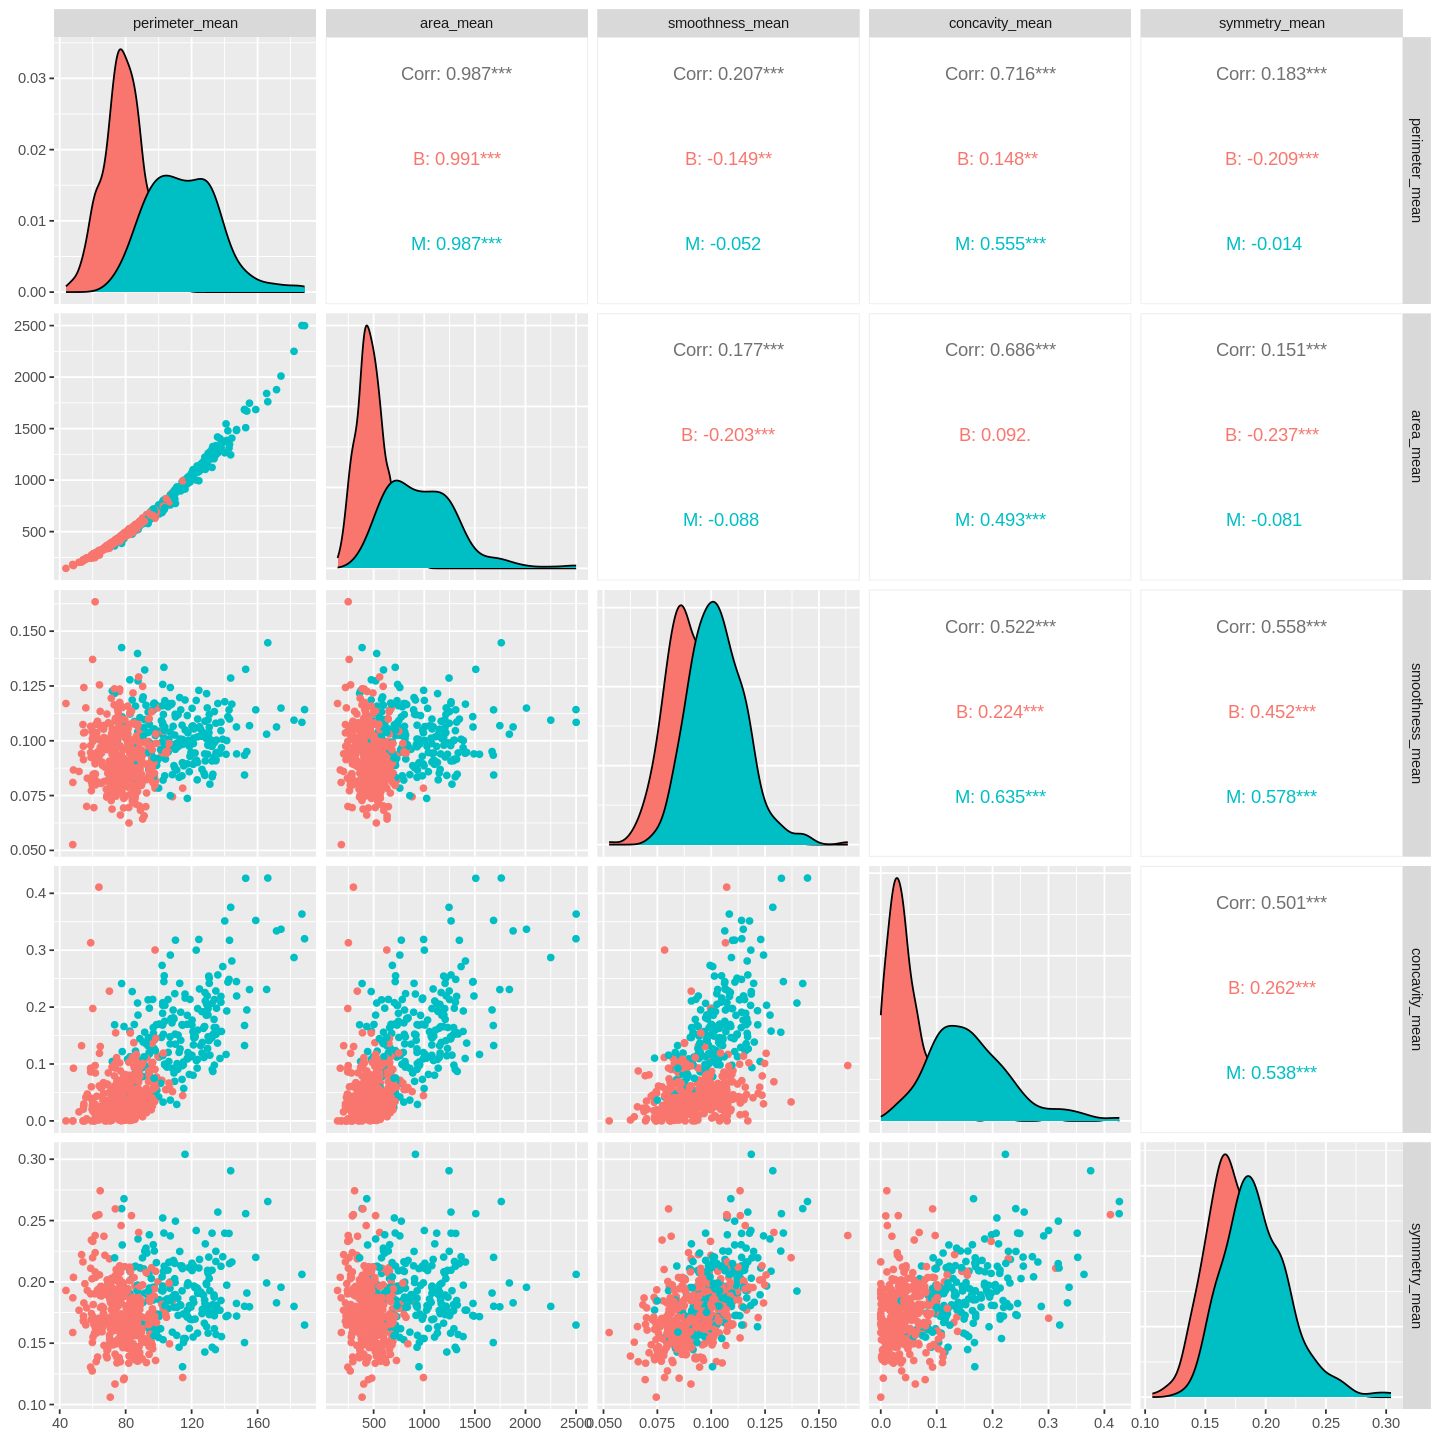

In [2]:
# Cargar las librerías
install.packages("GGally")
library(ggplot2)
library(GGally)

# Asegúrate de que df es tu dataframe en R
# Reemplaza 'diagnosis' por el nombre de la columna que contiene las categorías en tu dataframe

# Aumentar el área del gráfico
options(repr.plot.width = 12, repr.plot.height = 12)

# Gráfico de pares con GGally
ggpairs(df, columns = c('perimeter_mean', 'area_mean', 'smoothness_mean', 'concavity_mean', 'symmetry_mean'),
        ggplot2::aes(color = diagnosis))

Como sabemos, estos graficos nos muestran como se distribuye el atributo de diagnostico (benigno o maligno) entre cada par de variables seleccionadas. En la diagonal nos muestra la distribucion que tienen ambos valores de la variable diagnostico para una variable en particular. Algunas conclusiones de nuestro análisis preliminar podrían ser:
* ``area_mean`` y ``perimeter_mean`` tienen una clara correlación y determinan una separación abrupta. Cuando area_mean es mayor que aproximadamente 1,000, claramente el perimeter también aumenta, y el diagnóstico cambia de benigno a maligno de manera brusca. Por lo tanto, estos dos atributos son determinantes para el resultado final y es probable que uno de ellos sea redundante.

* Otras gráficas (por ejemplo, ``perimeter_mean``/``area_mean`` frente a ``smoothness_mean``, ``area_mean`` frente a ``symmetry_mean``, ``concavity_mean`` frente a ``smoothness_mean`` y ``concavity_mean`` frente a ``symmetry_mean``) muestran una separación horizontal (que se convierte en vertical al invertir el eje). Esto significa que, para casi todos los valores asumidos por la variable independiente (eje x), hay un umbral que separa los valores de la otra variable en dos conjuntos (benigno y maligno).

* Algunas gráficas (por ejemplo, ``perimeter_mean``/``area_mean`` frente a ``concavity_mean`` y ``concavity_mean`` frente a ``symmetry_mean``) muestran una ligera separación diagonal con pendiente negativa. Esto significa que cuando la variable independiente es pequeña, el diagnóstico permanece constante para casi todos los valores de la variable dependiente, mientras que, por otro lado, cuando la variable independiente se vuelve más grande, el diagnóstico cambia proporcionalmente al valor opuesto. Por ejemplo, para valores pequeños de ``perimeter_mean``, ``concavity_mean`` puede alcanzar su máximo sin afectar el diagnóstico (que es benigno), mientras que un ``perimeter_mean`` > 150 siempre resulta en un diagnóstico maligno independientemente de ``concavity_mean``.

Por supuesto, no podemos sacar fácilmente nuestras conclusiones de un análisis dividido (porque debemos considerar todas las interacciones), pero esta actividad será útil para proporcionar a cada grupo un etiquetado semántico

## t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-SNE (t-distributed Stochastic Neighbor Embedding) es una técnica de reducción de dimensionalidad no lineal no supervisada utilizada para explorar datos y visualizar datos de alta dimensionalidad. La reducción de dimensionalidad no lineal significa que el algoritmo nos permite separar datos que no pueden ser separados por una línea recta. Específicamente, modela cada objeto de alta dimensionalidad mediante un punto de dos o tres dimensiones de tal manera que objetos similares se modelan mediante puntos cercanos y objetos disimilares se modelan mediante puntos distantes con alta probabilidad.

El algoritmo t-SNE consta de dos etapas principales. Primero, t-SNE construye una distribución de probabilidad sobre pares de objetos de alta dimensionalidad de tal manera que objetos similares tienen asignada una probabilidad más alta, mientras que los puntos disímiles tienen asignada una probabilidad más baja. Segundo, t-SNE define una distribución de probabilidad similar sobre los puntos en el mapa de baja dimensionalidad y minimiza la divergencia Kullback-Leibler (divergencia KL) entre las dos distribuciones con respecto a las ubicaciones de los puntos en el mapa. Si bien el algoritmo original utiliza la distancia euclidiana entre objetos como base de su métrica de similitud, esto se puede cambiar según sea necesario. Una variante riemanniana es UMAP.

t-SNE se ha utilizado para la visualización en una amplia gama de aplicaciones, incluyendo genómica, investigación en seguridad informática, procesamiento de lenguaje natural, análisis de música, investigación sobre el cáncer, bioinformática, interpretación de dominio geológico y procesamiento de señales biomédicas. Si bien las representaciones de t-SNE a menudo parecen mostrar grupos, los grupos visuales pueden estar fuertemente influenciados por la elección de la parametrización y, por lo tanto, es necesario comprender bien los parámetros de t-SNE. Estos "grupos" pueden incluso aparecer en datos no agrupados y, por lo tanto, pueden ser hallazgos falsos. La exploración interactiva puede ser necesaria para elegir parámetros y validar resultados. Se ha demostrado que t-SNE a menudo es capaz de recuperar grupos bien diferenciados y, con elecciones de parámetros especiales, se aproxima a una forma simple de agrupación espectral.

Para más detalles, consulte "Visualizing Data using t-SNE", van der Maaten L., Hinton G., Journal of Machine Learning Research 9, 2008.

## Visualizacion de Data con t-SNE

En este punto, es útil visualizar el conjunto de datos (sin los atributos no estructurales) en un plano bidimensional a través de una transformación de t-Distributed Stochastic Neighbor Embedding (t-SNE)




Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



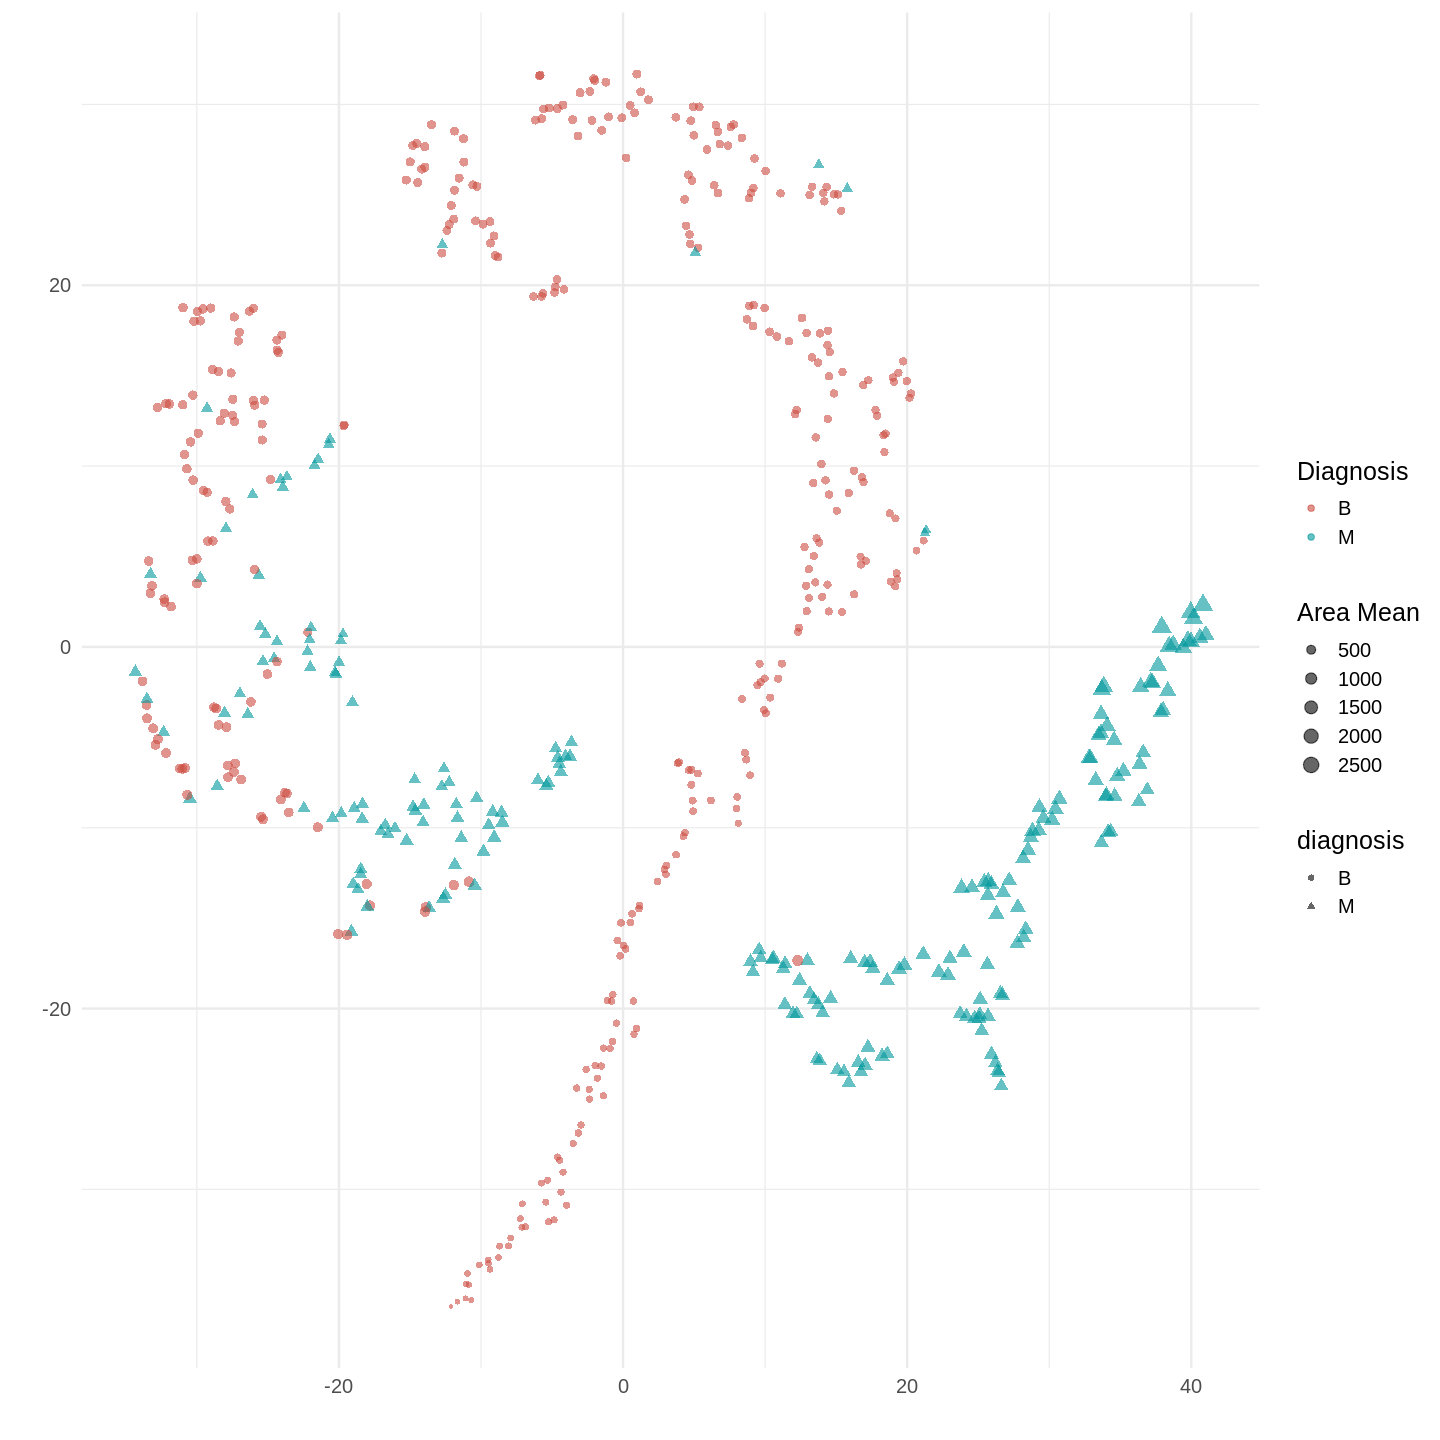

In [3]:
install.packages("Rtsne")
library(Rtsne)
cdf <- df %>% dplyr::select(-c(diagnosis, id))

# Aplicar t-SNE
set.seed(1000)
tsne_data <- Rtsne(cdf, is_distance = FALSE, dims = 2, perplexity = 10)
tsne_data_frame <- data.frame(x = tsne_data$Y[,1], y = tsne_data$Y[,2])

# Unir los datos t-SNE con el dataframe original
dff <- cbind(df, tsne_data_frame)


ggplot(dff, aes(x = x, y = y, color = diagnosis, size = area_mean)) +
  geom_point(aes(shape = diagnosis), alpha = 0.6) +
  scale_color_hue(l = 50) +  # usa una paleta de colores similar a "husl"
  scale_size(range = c(1, 4)) +  # ajusta el tamaño de los puntos
  theme_minimal(base_size = 15) +  # tema minimalista con tamaño de fuente ajustado
  labs(x = '', y = '', color = 'Diagnosis', size = 'Area Mean') +  # etiquetas de los ejes y leyendas
  theme(legend.position = "right")  # ajusta la posición de la leyenda

Un rápido análisis de la data nos puede hacer concluir que la mayoría de los datos pertenecientes a canceres malisnos se encuentran a la derecha de la recta $x=0$. Si bien algunos casos de cancer benigno nos pueden quedar a la derecha de dicha recta, debemos tener en cuenta que ninguna técnica de reducción de dimensionalidad nos dará la separación geométrica perfecta entre una cantidad de grupos $k$ (en este caso $k=2$).

## Aplicando K-Medias a la Data Reducida

En el siguiente código aplicaremos el algoritmo de K-medias a la data reducida en dimensionalidad producto de la técnica t-SNE.

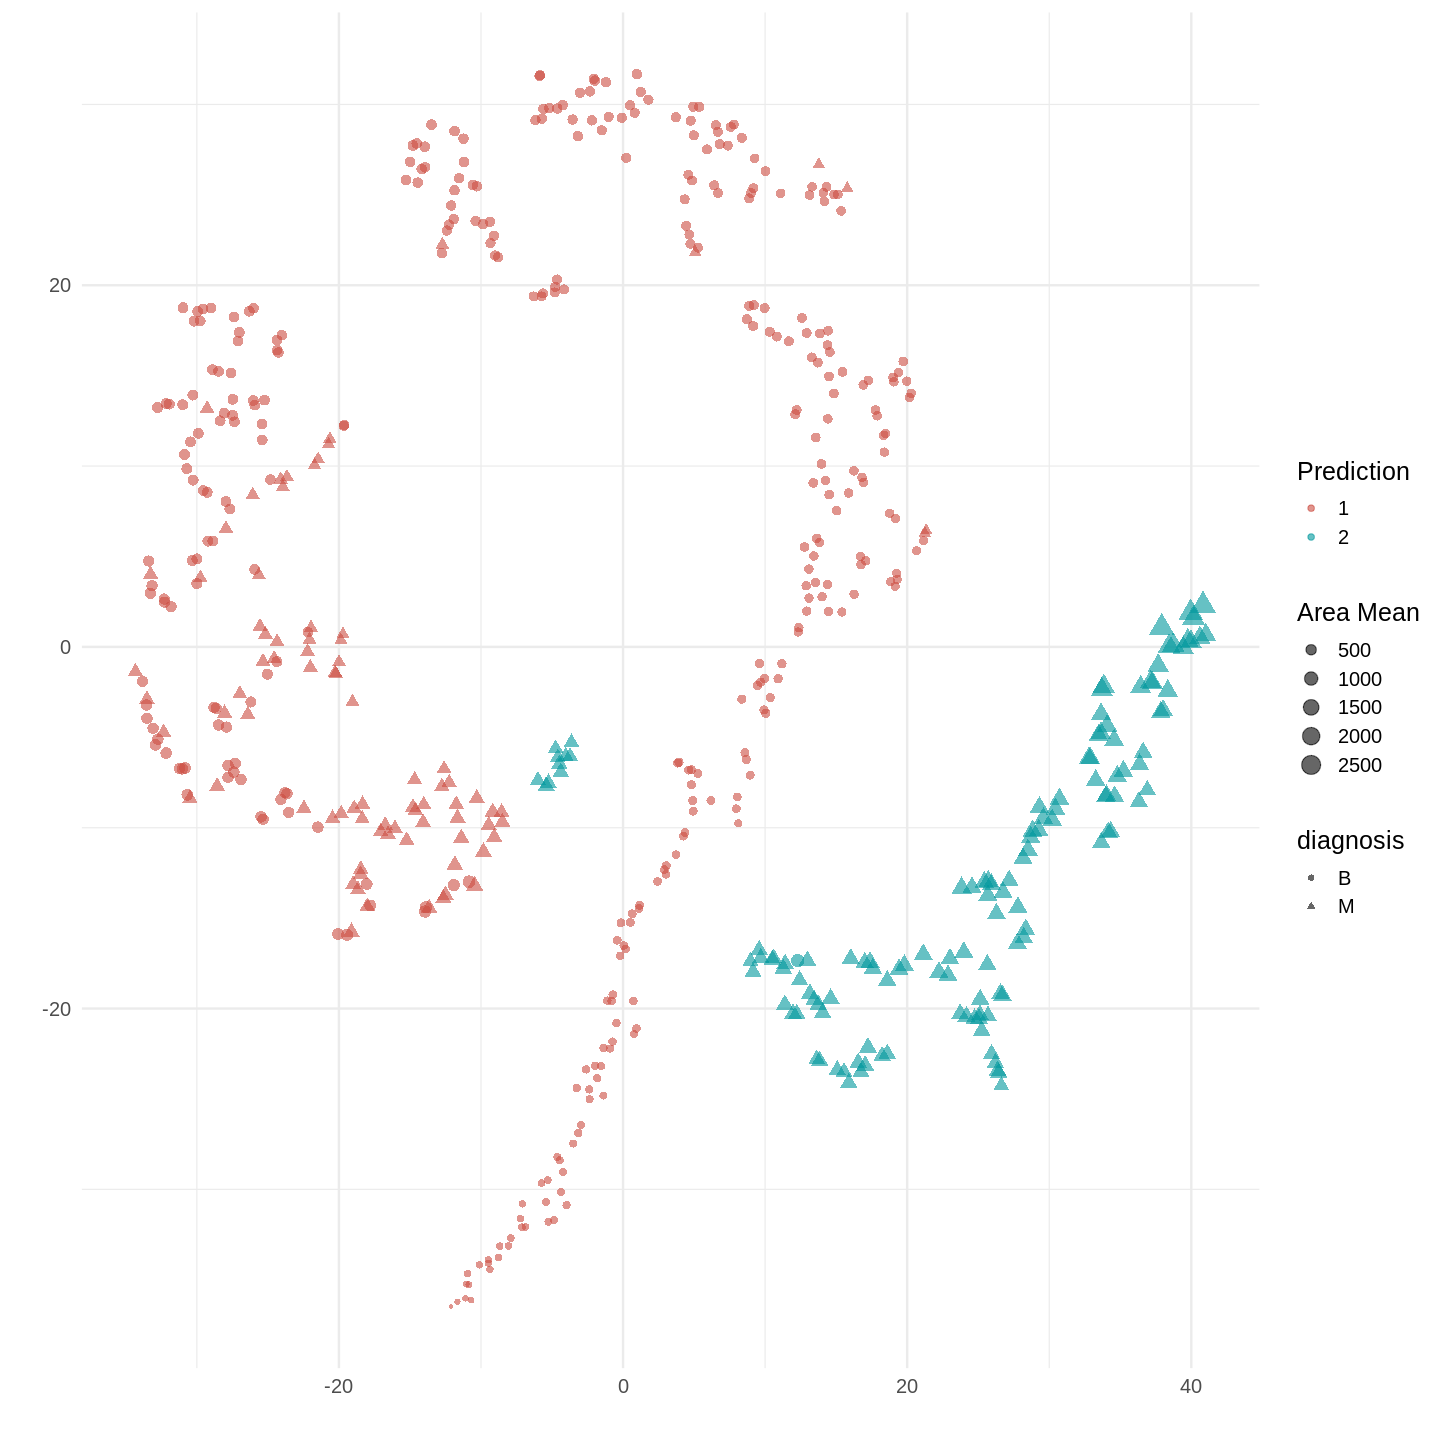

In [4]:
set.seed(1000)
km <- kmeans(cdf, centers = 2, nstart = 10, iter.max = 1000)
df_km <- data.frame(prediction = km$cluster)

# Combinamos los resultados con dff
kmdff <- cbind(dff, df_km)

# Graficamos los resultados
library(ggplot2)

ggplot(kmdff, aes(x = x, y = y, color = as.factor(prediction), size = area_mean)) +
  geom_point(aes(shape = diagnosis), alpha = 0.6) +
  scale_color_hue(l = 50) +  # Paleta de colores similar a "husl"
  scale_size(range = c(1, 5)) +  # Ajustar rango de tamaños
  theme_minimal(base_size = 15) +
  labs(x = '', y = '', color = 'Prediction', size = 'Area Mean') +
  theme(legend.position = "right")

Como era de esperar, el resultado es bastante preciso para $y < -20$, pero el algoritmo no logra incluir los puntos límite ($y ≈ 0$) en el grupo principal maligno. Esto se debe principalmente a la no convexidad de los conjuntos originales, y es muy difícil resolver el problema utilizando K-medias. Además, en la proyección, la mayoría de las muestras malignas con $y ≈ 0$ se mezclan con las benignas, por lo que la probabilidad de error también es alta con otros métodos basados en la proximidad. La única oportunidad de separar correctamente esas muestras se deriva de la distribución original. De hecho, si los puntos pertenecientes a la misma categoría pudieran ser capturados por conjuntos disjuntos en $\Re^{30}$, K-medias también podría tener éxito. Desafortunadamente, en este caso, el conjunto mezclado parece muy cohesionado, por lo que no podemos esperar mejorar el rendimiento sin una transformación. Sin embargo, para nuestros fines, este resultado nos permite aplicar las principales métricas de evaluación y luego pasar de $K=2$ a valores mayores. Con $K>2$, vamos a analizar algunos de los grupos, comparando su estructura con el gráfico de pares.

## Minimizar la Inercia

Uno de los mayores inconvenientes de K-medias y algoritmos similares es la solicitud explícita del número de agrupaciones. A veces, esta información está impuesta por restricciones externas (por ejemplo, en el caso de estudio, solo hay dos posibles diagnósticos), pero en muchos casos (cuando se necesita un análisis exploratorio), el científico de datos debe verificar diferentes configuraciones y evaluarlas. La forma más sencilla de evaluar el rendimiento de K-medias y elegir un número apropiado de grupos se basa en la comparación de diferentes inercias finales. Para explicar esto mediremos las inercias de un ejemplo generado a partir de 12 globos Gausianos muy compactos generados con la funcion de ```scikit-learn make_blobs()```

Comenzamos creando la data y mostrando resultados


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




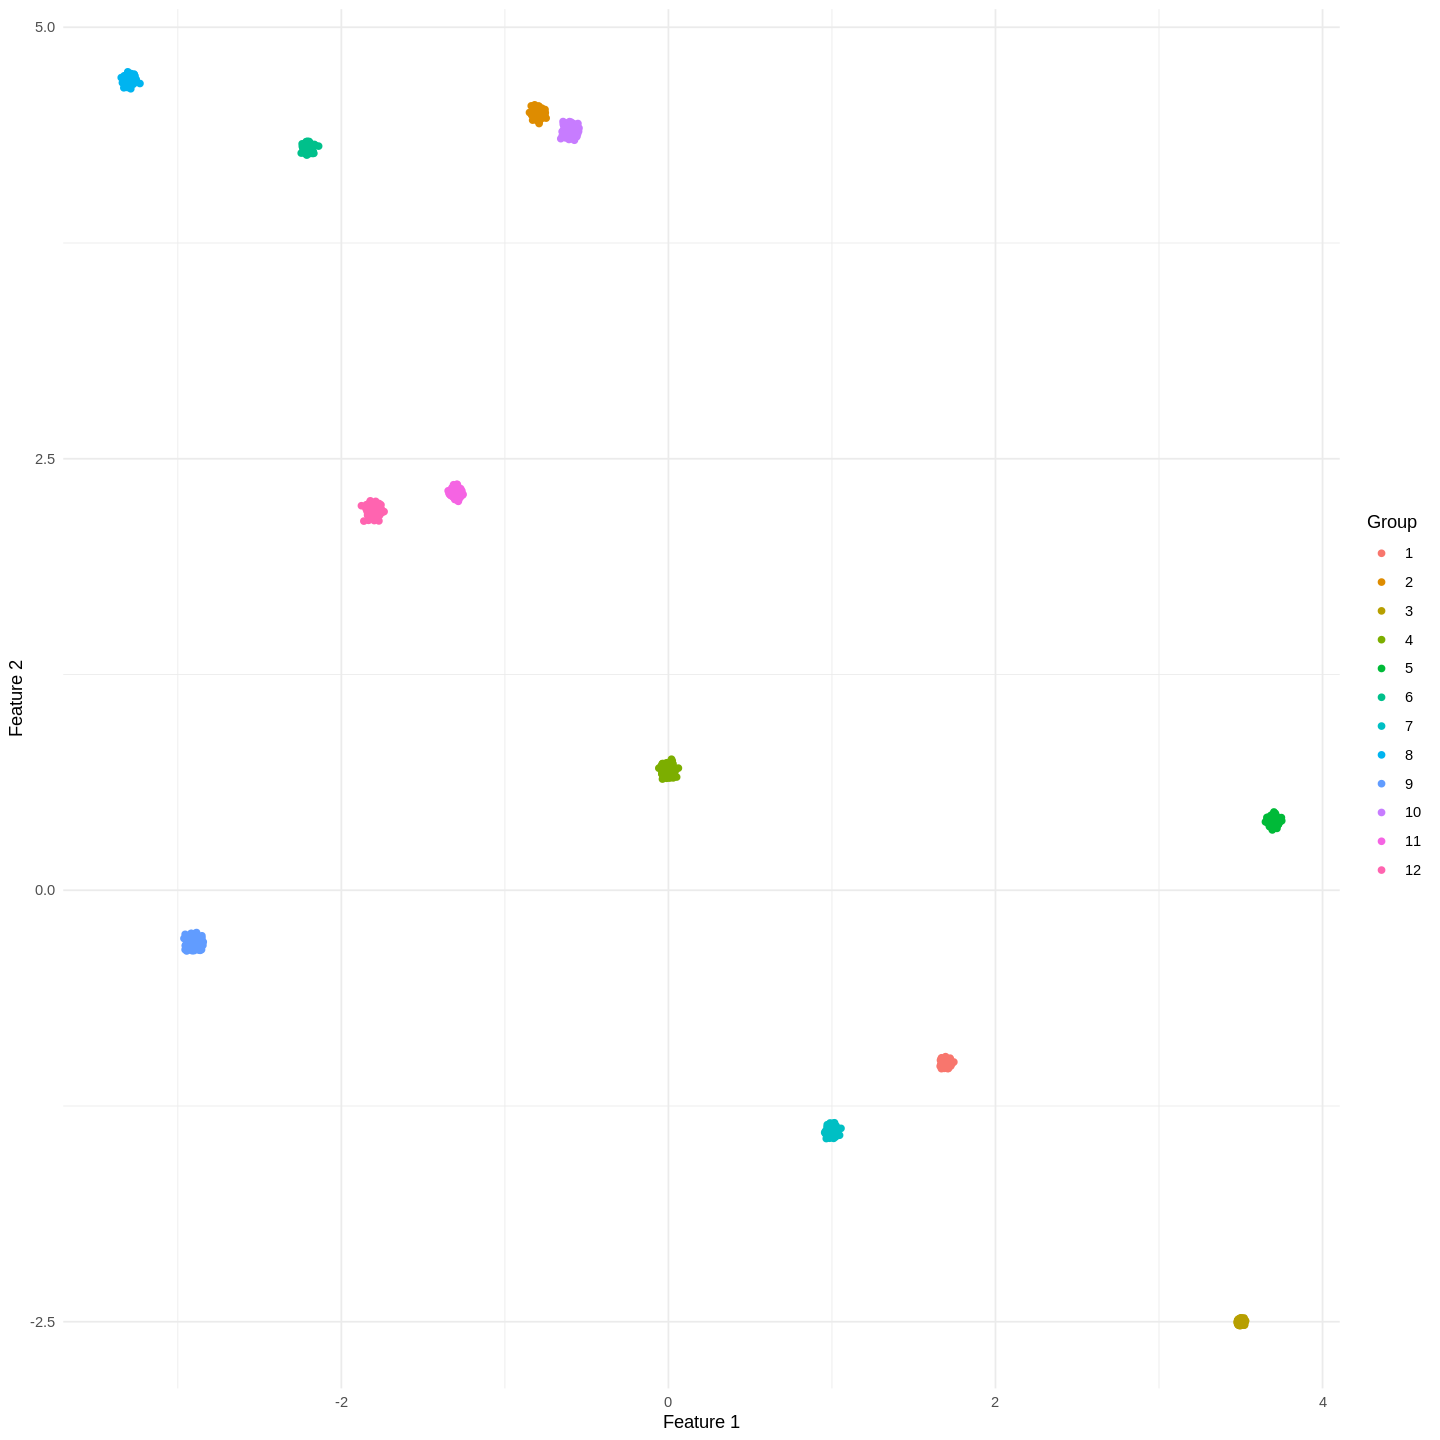

In [5]:
library(MASS)
set.seed(1000)  # Para reproducibilidad

n <- 200  # Número total de muestras por grupo
d <- 2    # Número de dimensiones
k <- 12    # Número de grupos

# Definir los centros y las desviaciones estándar para cada grupo
centers <- matrix(sample(-50:50, 24, replace = FALSE)/10, nrow = 12, ncol = 2)
std_devs <- sample(5:5, 12, replace = TRUE)/10000

data_list <- lapply(1:k, function(i) {
  mvrnorm(n, centers[i,], diag(std_devs[i], d))
})

# Combina los datos y crea una etiqueta para cada grupo
Blobs <- do.call(rbind, data_list)
Blobs <- as.data.frame(Blobs)
Blobs$group <- factor(rep(1:k, each = n))


ggplot(Blobs, aes(V1, V2, color = group)) +
  geom_point() +
  theme_minimal() +
  labs(x = "Feature 1", y = "Feature 2", color = "Group")

Ahora mostramos la grafica de la inercia para distintos números de agrupaciones y el código correspondiente.

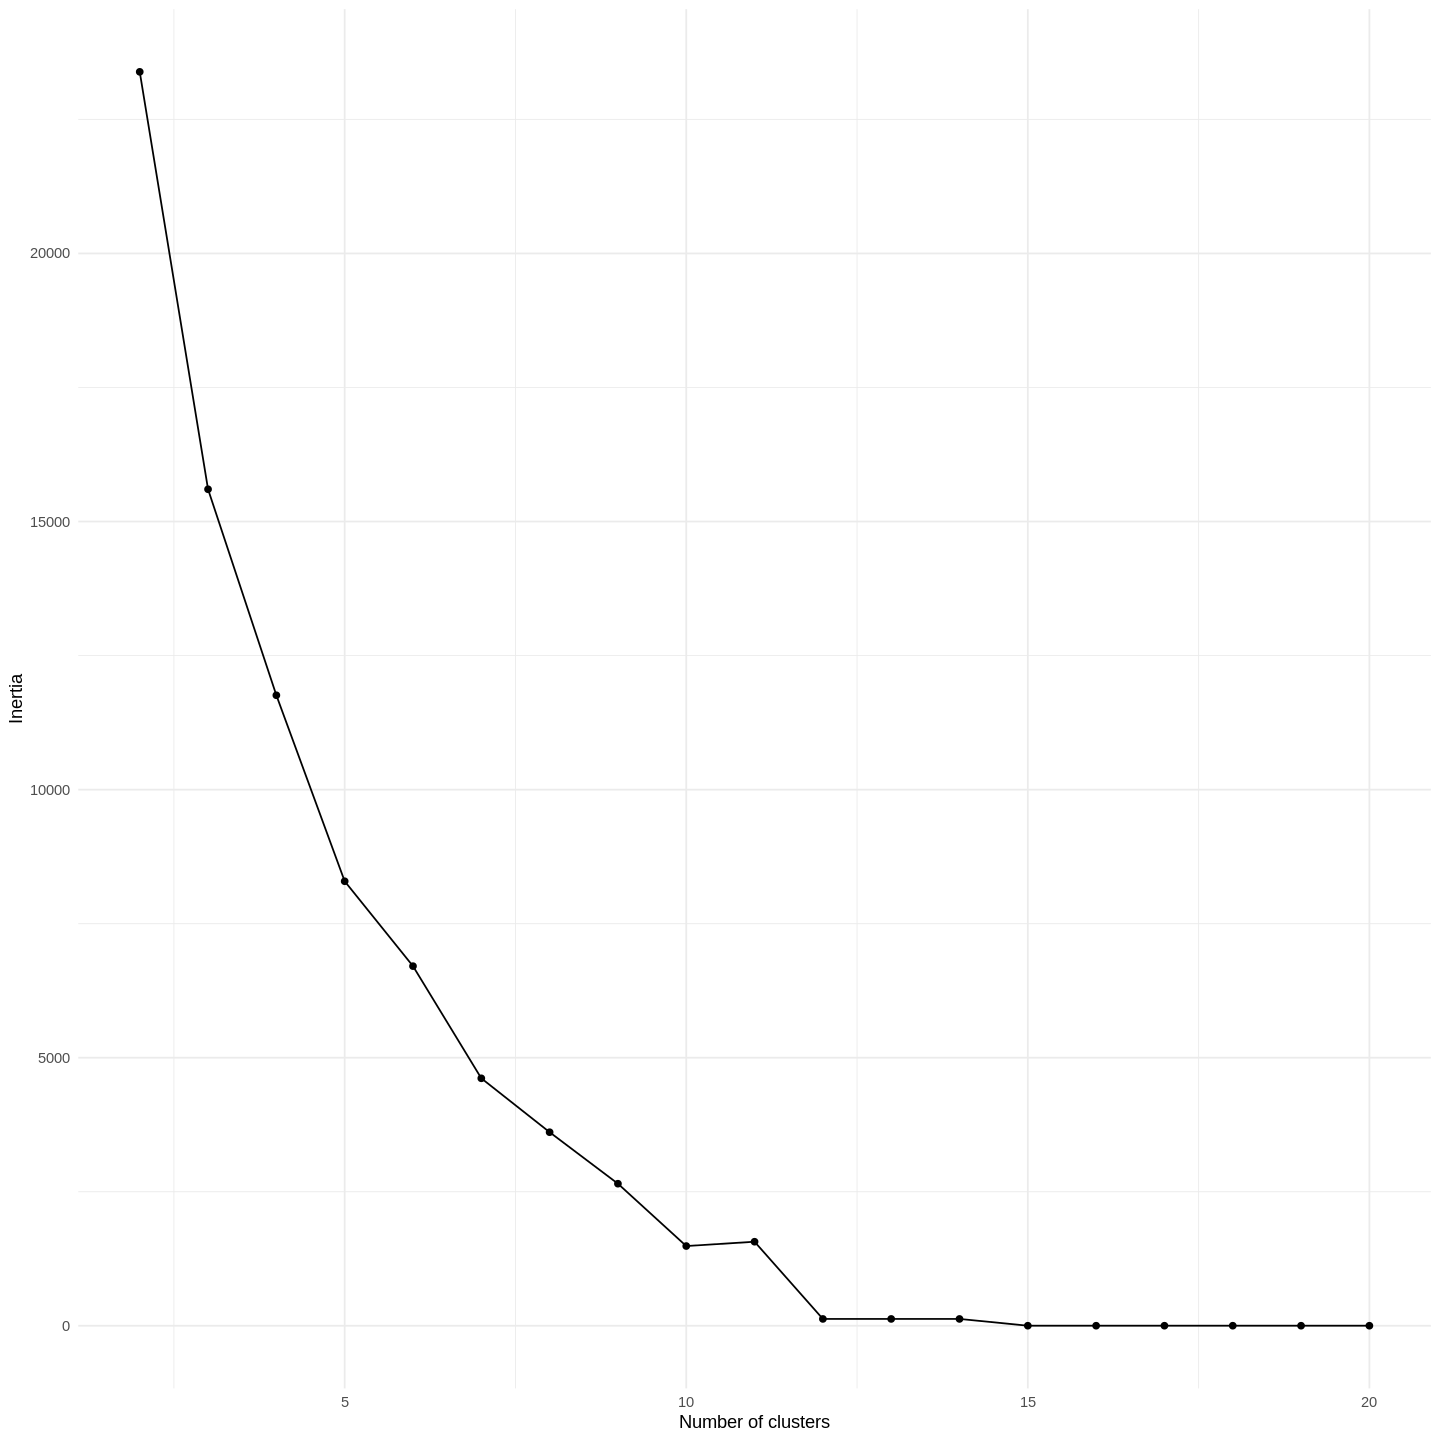

In [6]:
inertias <- numeric(19)  # Vector para almacenar inercias

for (i in 2:20) {
  set.seed(1000)  # Establecer una semilla para reproducibilidad
  km <- kmeans(Blobs, centers = i, nstart = 10, iter.max = 1000)
  inertias[i - 1] <- km$tot.withinss  # Almacenar la inercia
}

# Crear un dataframe para la visualización
df_inertia_blobs <- data.frame(
  clusters = 2:20,
  inertia = inertias
)

# Graficar inercia vs número de clusters
ggplot(df_inertia_blobs, aes(x = clusters, y = inertia)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  labs(x = "Number of clusters", y = "Inertia")

Algunos comentarios del proceso:
* El gráfico anterior muestra un comportamiento común. Cuando el número de grupos es muy pequeño, la densidad es proporcionalmente baja, por lo tanto, la cohesión es baja y, como resultado, la inercia es alta. Aumentar el número de grupos obliga al modelo a crear grupos más cohesionados y la inercia comienza a disminuir abruptamente.
* La regla heurística genérica (cuando no hay restricciones externas) es elegir el número de grupos correspondiente al punto que separa la región de alta variación de la casi plana, también conocida como técnica del codo (elbow criteria). La idea del "codo" es identificar el punto en el gráfico donde la disminución de la variabilidad comienza a aplanarse notablemente. Visualmente, este punto se parece a un codo en la gráfica. El punto de codo indica el número óptimo de clusters. Es el punto donde agregar un cluster adicional ya no proporciona mucha mejora en términos de reducción de variabilidad. Después de este punto, el beneficio de agregar más clusters se vuelve marginal en comparación con el costo computacional y la complejidad de interpretación.
* No obstante lo anterior, debemos tener cuidado al definir lo que entendemos por codo o punto en donde no existe valor agregado en incluir un grupo adicional. Para esto, es importante entender apropiadamente el contexto del problema con personas expertas en el negocio.
* Por supuesto, en este caso, si hubiéramos seleccionado K=15, nueve conjuntos habrían sido asignados a diferentes grupos, mientras que los otros tres se habrían dividido en dos partes. Obviamente, al dividir una región de alta densidad, la inercia sigue siendo baja, pero el principio de separación máxima ya no se sigue.

## Caso de Estudio: Minimizando la Inercia
Ahora revisaremos la inercia de nuestro caso de estudio para diferentes niveles de conglomerados (de 2 a 50)


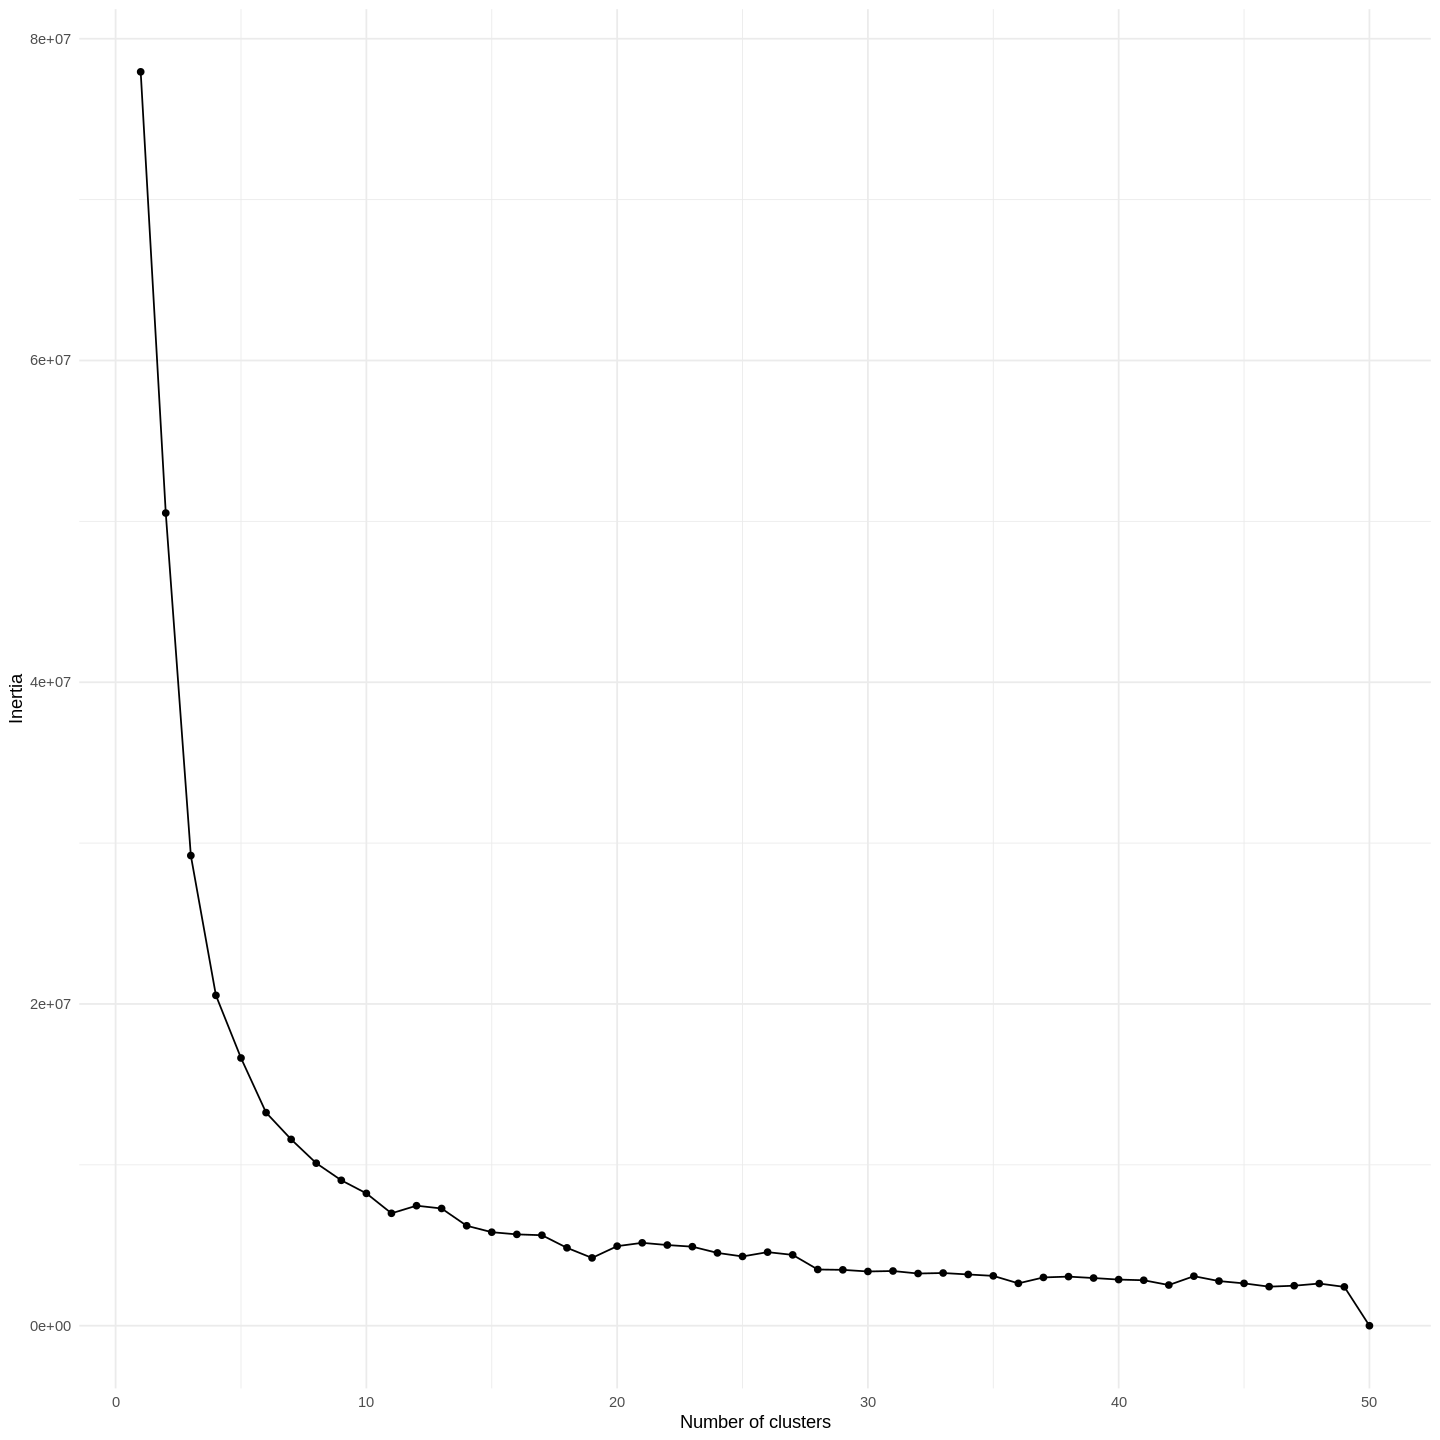

In [7]:
inertias <- numeric(50)  # Vector para almacenar inercias

for (i in 2:50) {
  set.seed(1000)  # Establecer una semilla para reproducibilidad
  km <- kmeans(cdf, centers = i, nstart = 10, iter.max = 1000)
  inertias[i - 1] <- km$tot.withinss  # Almacenar la inercia
}

# Crear un dataframe para la visualización
df_inertia <- data.frame(
  clusters = 1:50,
  inertia = inertias
)

# Graficar inercia vs número de clusters
ggplot(df_inertia, aes(x = clusters, y = inertia)) +
  geom_line() +
  geom_point() +
  theme_minimal() +
  labs(x = "Number of clusters", y = "Inertia")



En este caso, la verdad fundamental sugiere que deberíamos agrupar en dos grupos correspondientes a los diagnósticos. Sin embargo, el gráfico muestra un descenso drástico que termina en K=8 y continúa con una pendiente más baja hasta aproximadamente K=40. Durante el análisis preliminar, hemos observado que la proyección bidimensional está compuesta por muchos conjuntos aislados que comparten el mismo diagnóstico. Por lo tanto, podríamos decidir emplear, por ejemplo, K=8 y analizar las características correspondientes a cada grupo. Dado que esto no es una tarea de clasificación, la verdad fundamental puede usarse como la principal referencia, pero un análisis exploratorio correcto puede intentar comprender la composición de las subestructuras para proporcionar detalles adicionales a los técnicos (por ejemplo, médicos). Ahora realizaremos un agrupamiento K-medias con ocho grupos en el conjunto de datos para describir la estructura de dos grupos de muestra, de la siguiente manera:

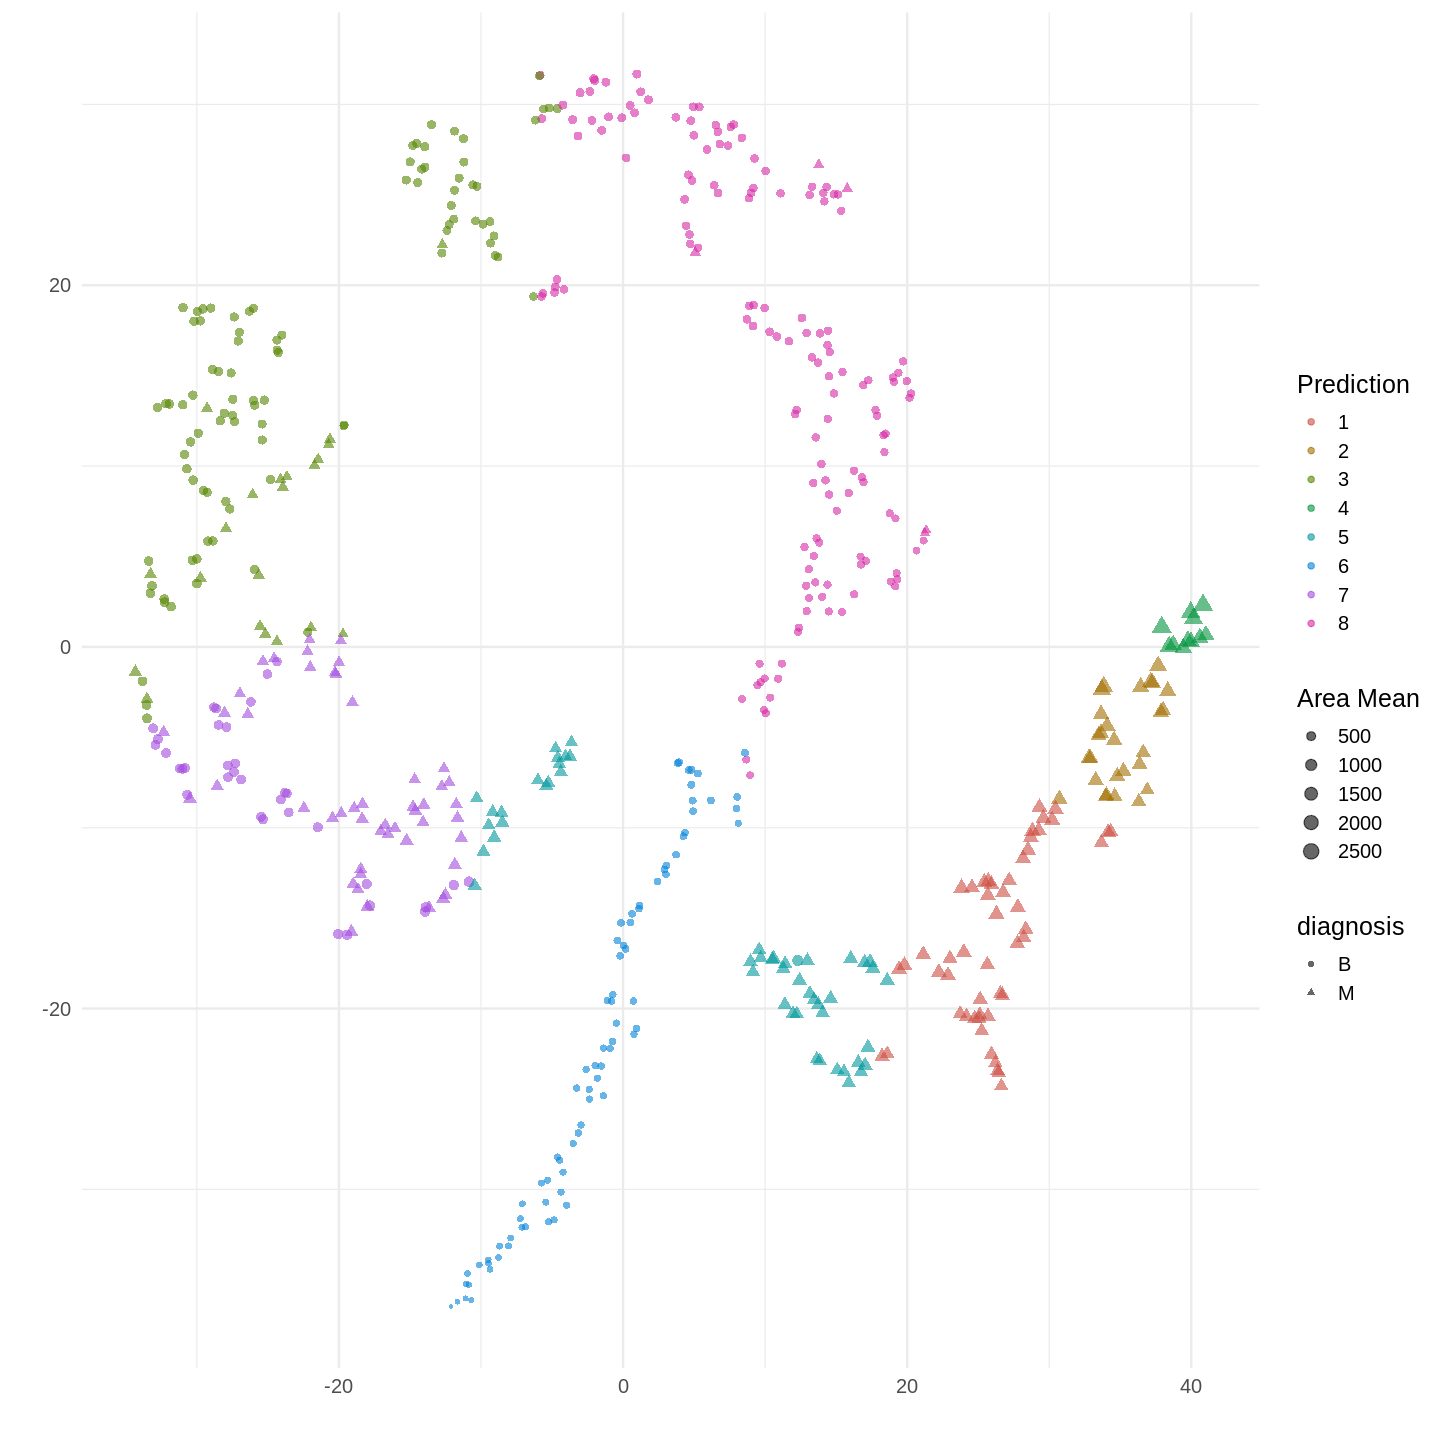

In [8]:
# Clustering con K-medias
set.seed(1000)
km <- kmeans(cdf, centers = 8, nstart = 10, iter.max = 1000)
df_km <- data.frame(prediction = km$cluster)

# Combinamos los resultados con dff
kmdff <- cbind(dff, df_km)

# Graficamos los resultados
library(ggplot2)

ggplot(kmdff, aes(x = x, y = y, color = as.factor(prediction), size = area_mean)) +
  geom_point(aes(shape = diagnosis), alpha = 0.6) +
  scale_color_hue(l = 50) +  # Paleta de colores similar a "husl"
  scale_size(range = c(1, 4)) +  # Ajustar rango de tamaños
  theme_minimal(base_size = 15) +
  labs(x = '', y = '', color = 'Prediction', size = 'Area Mean') +
  theme(legend.position = "right")

Ahora, consideremos el intervalo $10 < x < 50$ y $-30 < y <10$ y revisemos estadística descriptiva sencilla de algunos de sus atributos.

In [10]:
sdff_1 <- dff %>%
  filter(x > 10.0, x < 50.0, y > -30.0, y < 10.0)
summary(sdff_1[,c('perimeter_mean', 'area_mean', 'smoothness_mean', 'concavity_mean', 'symmetry_mean')])

 perimeter_mean     area_mean      smoothness_mean   concavity_mean     
 Min.   : 68.69   Min.   : 359.9   Min.   :0.06883   Min.   :0.0009737  
 1st Qu.: 76.33   1st Qu.: 420.5   1st Qu.:0.09014   1st Qu.:0.0829925  
 Median :122.05   Median :1076.0   Median :0.09860   Median :0.1428500  
 Mean   :115.70   Mean   :1012.8   Mean   :0.09907   Mean   :0.1463062  
 3rd Qu.:133.43   3rd Qu.:1263.2   3rd Qu.:0.10705   3rd Qu.:0.1978500  
 Max.   :188.50   Max.   :2501.0   Max.   :0.14470   Max.   :0.4268000  
 symmetry_mean   
 Min.   :0.1167  
 1st Qu.:0.1720  
 Median :0.1832  
 Mean   :0.1877  
 3rd Qu.:0.2015  
 Max.   :0.3040  

Desde la verdad fundamental, sabemos que todas estas muestras son malignas, pero podemos intentar determinar una regla. La relación entre el área media y el perímetro medio es aproximadamente de 9.23 y las desviaciones estándar relativas son muy pequeñas en comparación con las medias. Esto significa que estas muestras representan tumores extendidos en un rango muy estrecho. Además, tanto la concavidad media como la simetría media son mayores que los valores generales. Por lo tanto (sin la presunción de un análisis científicamente razonable), podemos concluir que las muestras asignadas a estos grupos representan tumores muy graves que han alcanzado una etapa avanzada.

### Conclusiones del Ejercicio

En este caso, la relación entre el área media y el perímetro medio es aproximadamente de 4.89, pero el área media tiene una desviación estándar más grande (de hecho, su valor máximo es de alrededor de 410). La concavidad media es extremadamente pequeña en comparación con la anterior (incluso con aproximadamente la misma desviación estándar), mientras que la simetría media es casi equivalente. A partir de este breve análisis, podemos deducir que la simetría media no es una característica discriminante, mientras que una relación entre el área media y el perímetro medio menor que 5.42 (considerando los valores máximos) con una concavidad media menor o igual a 0.04 debería garantizar un resultado benigno. Dado que la concavidad media puede alcanzar un valor máximo muy grande (mayor que el asociado con muestras malignas), es necesario considerar también las otras características para decidir si su valor debe ser considerado como una alarma. Sin embargo, podemos concluir diciendo que todas las muestras pertenecientes a estos grupos son benignas con una probabilidad de error insignificante

Es importante recalcar que esto es más un ejercicio que un análisis real y, en tales situaciones, la tarea principal del científico de datos es recopilar piezas de información contextual que puedan respaldar las conclusiones. Incluso en presencia de la verdad fundamental, este proceso de validación es siempre obligatorio porque la complejidad de las causas subyacentes puede llevar a afirmaciones y reglas completamente erróneas

